# Quickstart Guide for `tofhed` Package

Welcome to the introductory guide for the `tofhed` package. This tutorial is designed to help you get started with the basic functionalities of the package.

**Prerequisites**:
- Ensure you've installed the `tofhed` package and its associated dependencies.

[Installation Guide](installation.ipynb)

**Objectives**:

1. Set up the database.
2. Import data from an `.xyz` file.
3. Identify surface atoms of a catalyst.
4. Analyze solid angles using the Hinuma Algorithm.

Let's dive right in!

# Step 1: Setting Up the `tofhed` Package

## 1.1 Importing the Package

First, let's import the necessary module from the `tofhed` package.


In [1]:
# Importing the DataBase class from tofhed package
from tofhed.commander import DataBase

# Creating an local SQLite database
data = DataBase('examples/test.db')

# If you prefere to create a in-memory SQLite database use the following line instead
# data = DataBase()

# Specifying the path to our sample .xyz file
path_xyz = 'examples/FeCO_example.xyz'

# Step 2: Defining Settings for `.xyz` File Import

Before importing our `.xyz` file, we need to define some specific settings. These settings will be saved as a dictionary. Here's a detailed breakdown:


- **Hinuma Cutoff**: Represents the cutoff radius (in Angstroms) for the Hinuma Algorithm. This cutoff dictates the sphere's radius around the central atom, deciding which surrounding atoms to include in calculations. Typical values range between 5.0 and 6.0 Angstroms.

- **Minimum Image Convention (mic)**: A Boolean value that indicates if the calculation should apply the minimum image convention.

- **Zero Vector Tolerance**: A threshold for the zero vector. Should the distance between two atoms fall below this value, the distance defaults to zero. This adjustment prevents divide-by-zero errors.

- **Solid Angle Limit**: This post-Hinuma Algorithm value discerns surface atoms. If an atom's solid angle exceeds this value, it's deemed a surface atom.

- **Base Type Algorithm**: This lets users select the algorithm for distinguishing catalyst atoms from chemical atoms. For our example, we'll use a chemical elements list to delineate the chemical atoms.

- **Chemical Elements**: A list of chemical elements marking the chemical atoms. Given our example file employs C, H, and O elements for chemical atoms, we'll specify them, separated by spaces.

In [2]:
# Settings dictionary for the tofhed package operations
settings_dict = {
    'hinuma_cutoff': 6.0,  # Cutoff radius (in Angstroms) for the Hinuma Algorithm
    'mic': False,  # Indicates if the calculation should apply the minimum image convention
    'zero_vec_tolerance': 0.0000001,  # Threshold for the zero vector
    'init_frame_number': 5,  # Frame number for initialization
    'solid_angle_limit': round(2 * 3.14 * 0.7, 3),  # Solid angle threshold for surface atoms
    
    'base_type_algorithm': 'chemical_elements',  # Algorithm for distinguishing catalyst from chemical atoms
    'chemical_elements': 'H C O',  # List of chemical elements for chemical atoms
}

With these settings in place, you're now prepared to proceed with the tofhed package operations.

# Step 3: Starting the Experiment with the `tofhed` Package

With our settings defined, we can proceed to utilize the `tofhed` package.

## 3.1 Importing the `.xyz` File

First, let's import the `.xyz` file to create an experiment instance.

In [3]:
# Importing the .xyz file and creating an experiment instance
experiment = data.import_experiment_from_file(path_xyz, settings_dict, import_positions=True)

## 3.2 Visualizing the System

Visualizing the chemical system helps in ensuring the accuracy of our configuration. Let's use the `matplot` function to get a graphical representation of our system.

*Note*: The visualization might look different based on your local setup.

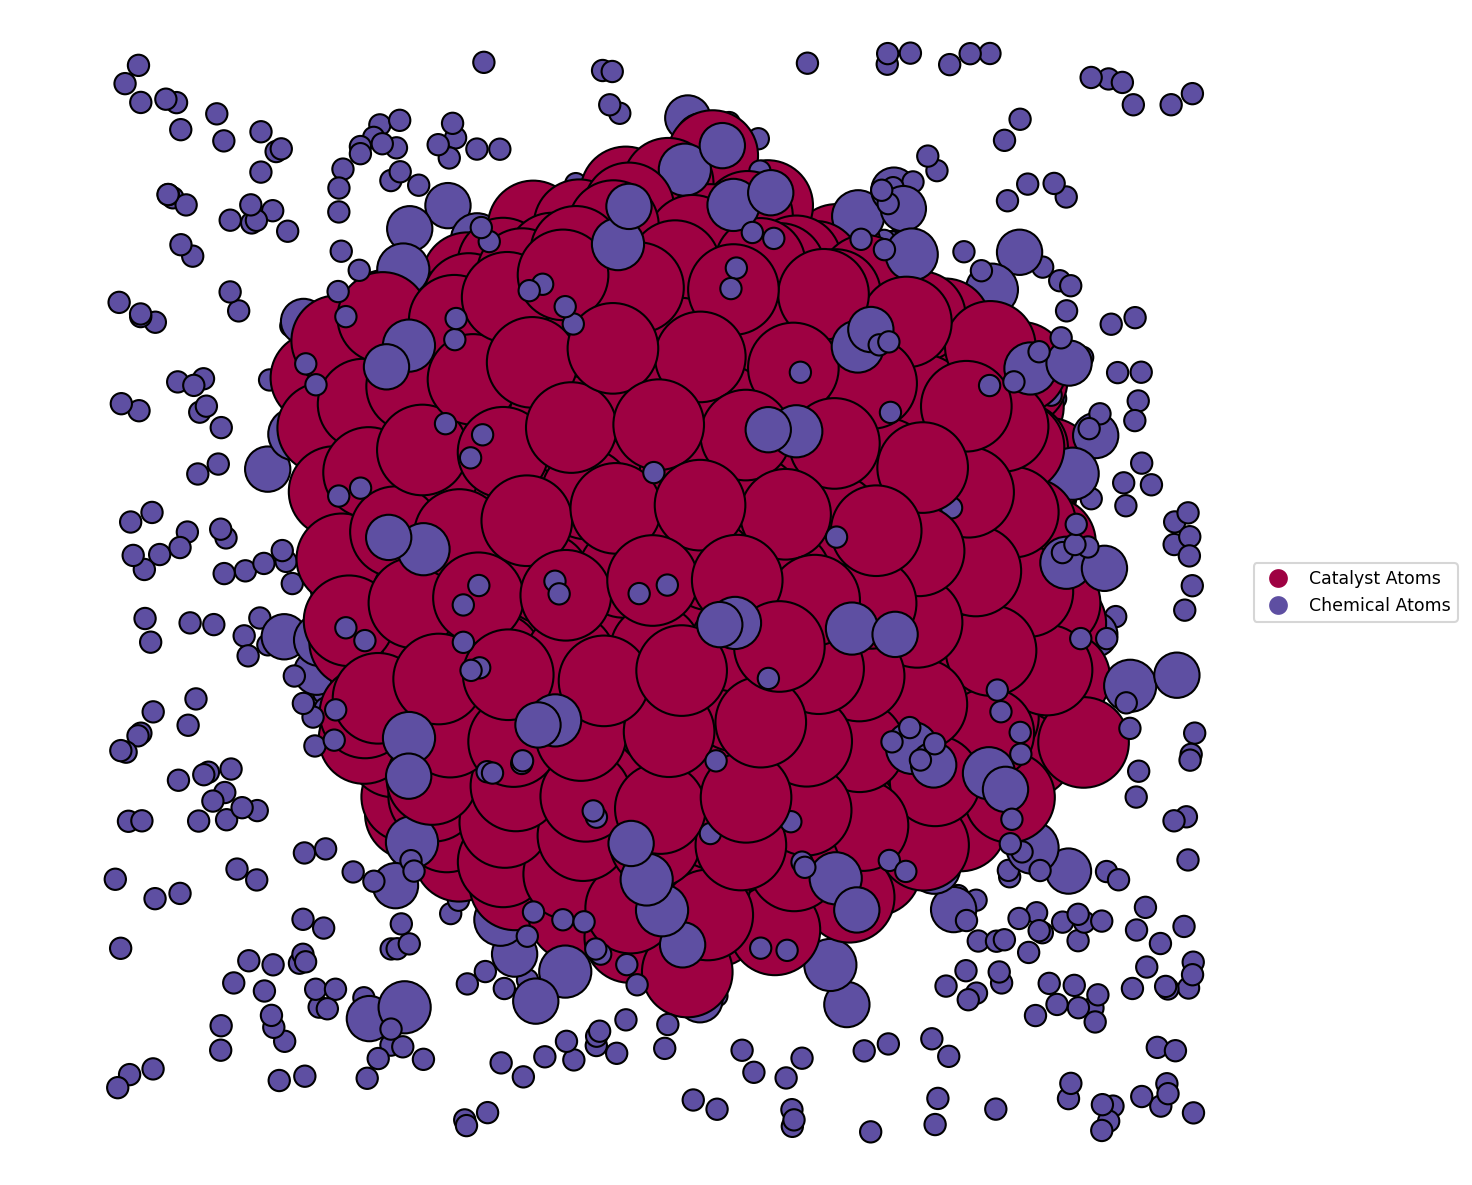

In [4]:
# Visualizing the system using matplotlib
experiment.view.matplot(cut=False, rotation='90x, 0y, 0z')

## 3.3 Interactive Visualization using ASE GUI

For those who prefer a more interactive experience, the ASE GUI offers a hands-on approach to inspect the structure. By using the ASE GUI, you can differentiate components based on user-defined tags:

1. Run the command below to launch the ASE GUI.
2. In the GUI, select the atomic structure.
3. Press `c` on your keyboard to toggle the coloring mode to 'By user defined tags'.

*Note*: Ensure you have the ASE GUI installed and properly configured on your system.

In [5]:
# Launching the ASE GUI for a more interactive visualization
experiment.view.split()

## 3.4 Surface Detection

Detecting the surfaces is a critical step, especially when focusing on catalyst atoms. This process will help identify the surface areas of our chemical system. Please note that depending on the complexity of the system, this step might take a few moments.


In [6]:
# Detecting surfaces of the system
surfaces = experiment.set_new_surfaces()
print(surfaces)

SurfaceGroup ID 1 - Surfaces: 1


## 3.5 Visualizing Internal Structures

From the previous step, we observed that only a single surface was recognized. To get a clearer insight into the internal structure of our system, we can slice it in two and visualize it.

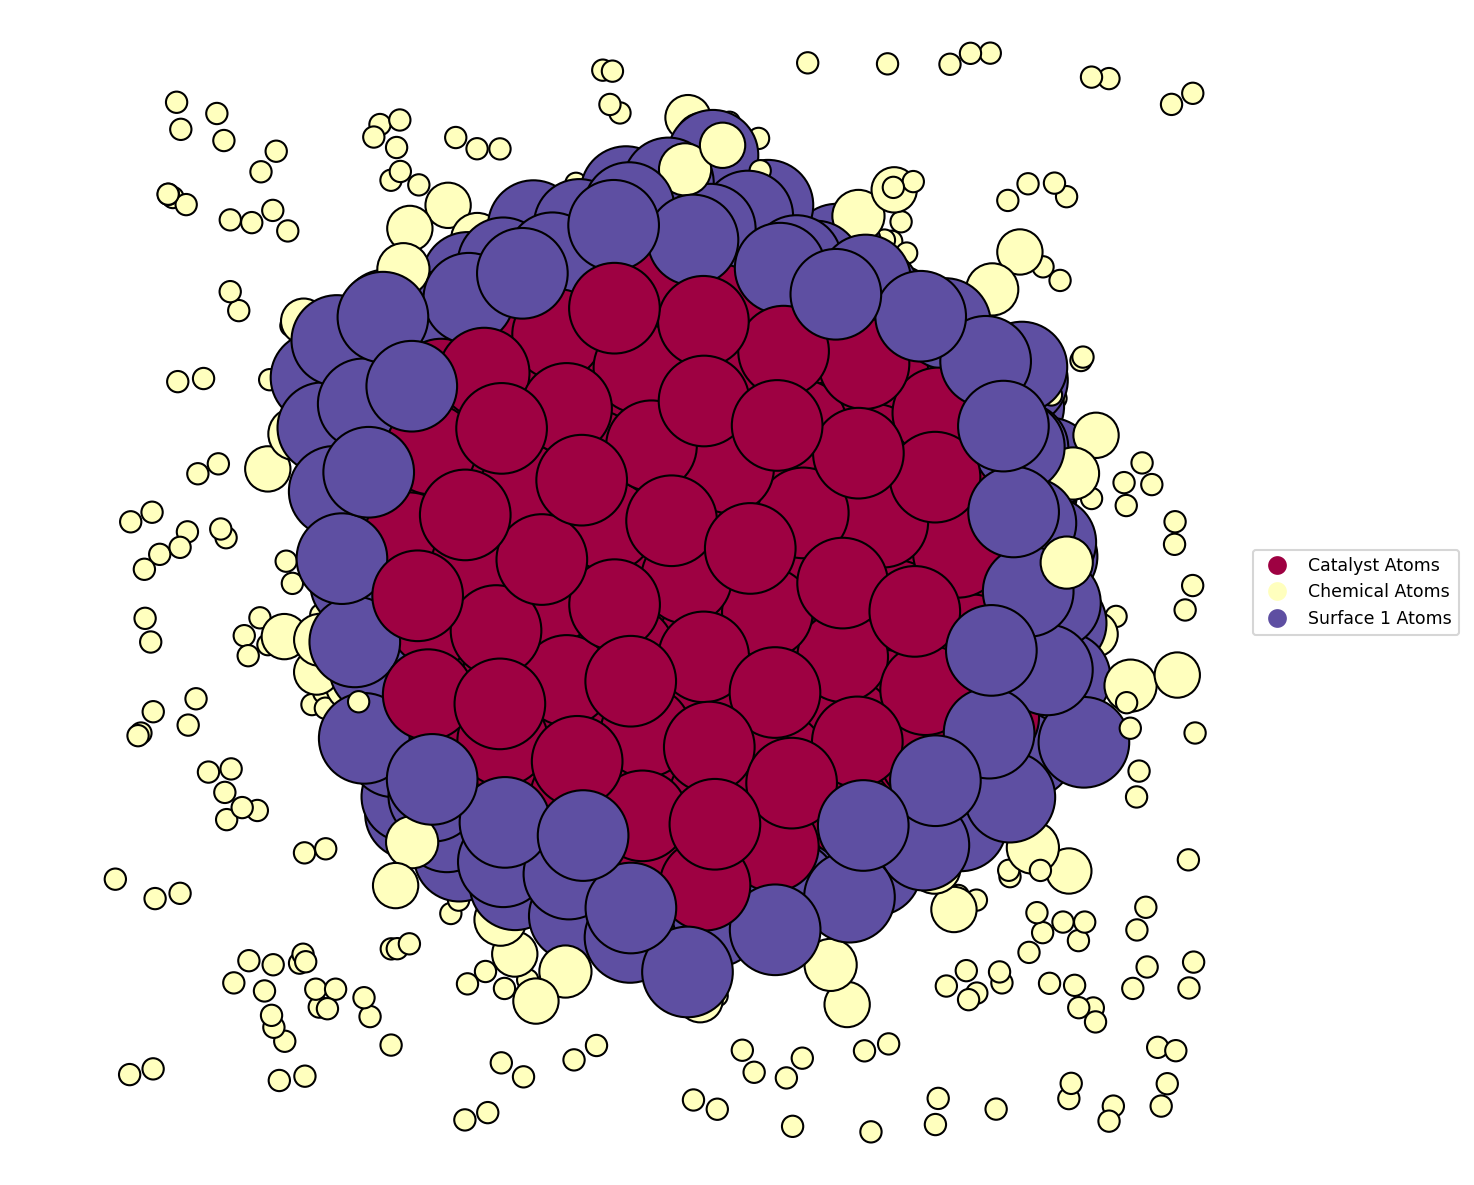

In [7]:
# Slicing the system and visualizing its internal structure
experiment.view.matplot(cut=True, rotation='90x, 0y, 0z')

## 3.6 Understanding the Hinuma Algorithm

The Hinuma Algorithm is pivotal in the surface detection process. This algorithm categorizes atoms as either surface or internal based on their calculated solid angles. Visualizing these solid angles can provide a clearer insight into the atom categorization process.

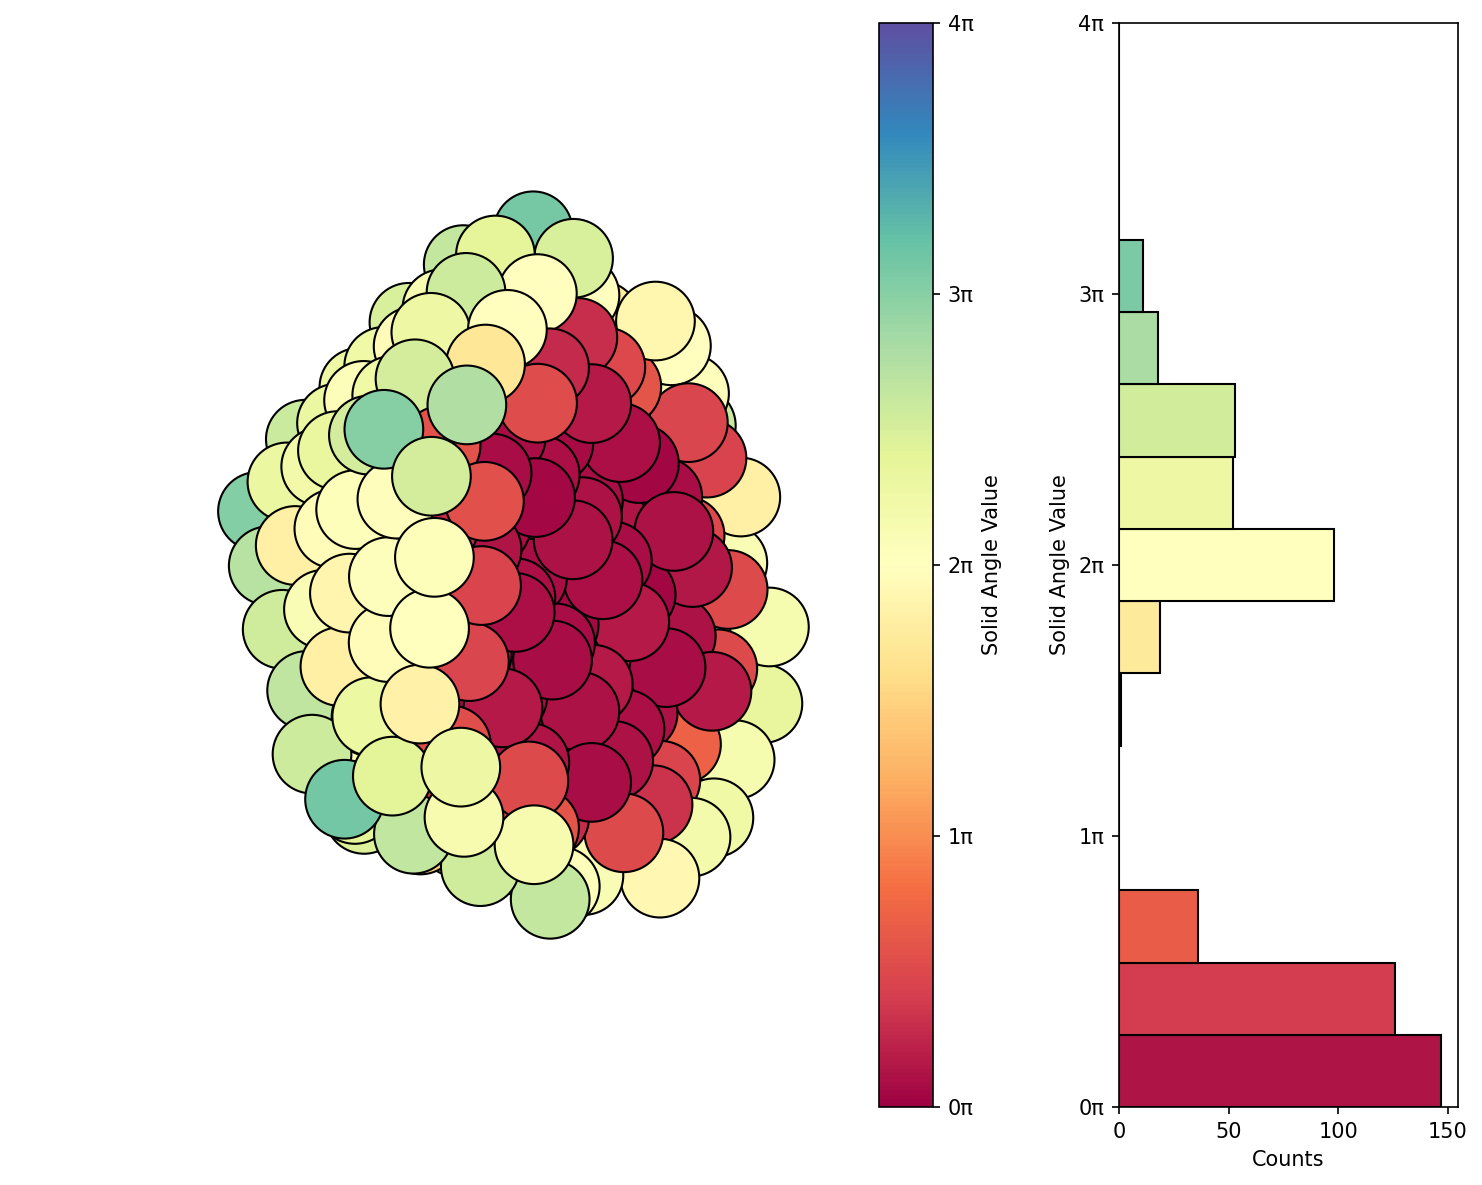

In [8]:
# Visualizing solid angles for atom categorization using the Hinuma Algorithm
experiment.view.matplotlib_hinuma(experiment, hinuma_id=1, cut=True, 
                                  rotation='90x, 60y, 0z', plot_histogram=True)

## 3.7 Further Analysis of Surface Detection

With our visualization in place, we can perform deeper analyses on the data. This will allow us to better understand the results and the implications of our configurations.

Let's start by fetching all frame numbers from the experiment.

*Note*:
When working with datasets, it's imperative to understand the distinction between ids and numbers:

- Numbers (numbers): These represent positions or orderings as they appear in the original data files. Whether you're dealing with frames, atoms, or any other sequential data, you would use numbers to refer to their sequence in the source files.

- Unique Identifiers (ids): ids are unique identifiers that are generated by the database due to its relational nature. These identifiers ensure each entity, be it a frame or an atom, is distinct within the database. They are crucial for ensuring accuracy and precision in internal referencing and operations.

Given their distinct roles, it's vital to use ids and numbers in their appropriate contexts. Interchanging them can lead to misinterpretations or errors. Always remember: use ids for precise internal database references, given their uniqueness and auto-generation by the database, and use numbers when referencing original data file orderings.

In [9]:
# Fetching all frame numbers associated with the experiment
frame_numbers = experiment.frames.numbers

To find out, for which frames we already have calculated the Hinuma solid angles, we can iterate over all `hinumas` in our experiment. Let's create a dictionary to map the `frame_id` to the `hinuma_id`:

In [10]:
# Creating a dictionary mapping frame IDs to Hinuma IDs
hinuma_frames_dict = {hinuma.frame_id: hinuma.id for hinuma in experiment.hinumas}

## 3.8 Generating a List of Desired Frame IDs

In many analyses, it's unnecessary to compute metrics for every single frame, especially when dealing with extensive datasets. By strategically selecting specific frames, we can not only expedite our calculations but also ensure computational efficiency. In this demonstration, we'll focus on computing the solid angles for intervals, specifically every 5th frame.

In [11]:
# Define the starting and ending frames for our analysis
start_frame = 0
end_frame = max(frame_numbers)

# Set the interval at which we want to select frames (e.g., every 5th frame)
step = 5

# Initialize an empty list to store the selected frame IDs
selected_frame_ids = []

# Iterate over frames from start to end at the specified interval (step)
for i in range(start_frame, end_frame, step):
    # Get the frame number corresponding to the current index
    frame_number = frame_numbers[i]
    
    # Convert the frame number to its unique frame ID using the experiment's mapping
    frame_id = experiment.frames.number_to_id[frame_number]

    # Check if the Hinuma for the frame has already been calculated
    if frame_id in hinuma_frames_dict:
        print(f'Hinuma for frame {frame_number} has already been calculated')
    else:
        # If not, add the frame ID to our list of selected frame IDs
        selected_frame_ids.append(frame_id)

# Return the list of selected frame IDs for further processing or analysis
selected_frame_ids

Hinuma for frame 5 has already been calculated


[1, 11, 16, 21, 26, 31, 36, 41, 46]

## 3.9 Optimizing Computation Through Parallel Processing
With our frames of interest identified, it's time to optimize our computations. We'll allocate specific CPU cores for parallel processing, enhancing the speed of our calculations. Keep in mind, the time taken can vary based on the intricacies of the settings.

In [12]:
# Specify the number of CPU cores dedicated for parallel processing
n_cores = 6
experiment.hinumas._set_new_hinumas_parallel(selected_frame_ids, n_cores=n_cores)

Cores used: 1


{2: hinuma_id=2,
 3: hinuma_id=3,
 4: hinuma_id=4,
 5: hinuma_id=5,
 6: hinuma_id=6,
 7: hinuma_id=7,
 8: hinuma_id=8,
 9: hinuma_id=9,
 10: hinuma_id=10}

## 3.10 Collecting Solid Angles for All Calculated Hinumas
When working with solid angles in the context of Hinumas, there are instances where the solid angle cannot be computed, resulting in a value of None. To ensure the consistency and accuracy of our dataset, we filter out these non-computed values and focus solely on valid floating-point solid angles.

In [13]:
import numpy as np
from collections import defaultdict

# Dictionary to store solid angles for each atom
all_solid_angles = defaultdict(list)

# Mapping of frame IDs to their respective Hinuma IDs
used_hinumas = {hinuma.frame_id: hinuma.id for hinuma in experiment.hinumas}

# Iterate over all used Hinumas
for hinuma_id in used_hinumas.values():
    hinuma = experiment.hinumas[hinuma_id]
    
    # Collect solid angles for each atom, filtering out 'None' values
    for atom_id, solid_angle in hinuma.solid_angles.items():
        if isinstance(solid_angle, float):
            all_solid_angles[atom_id].append(solid_angle)


With our dataset in place, our next step is to compute the average solid angle for each atom. This aggregated metric offers insights into the overall distribution and patterns of solid angles across atoms. Let's calculate and visualize these averages.

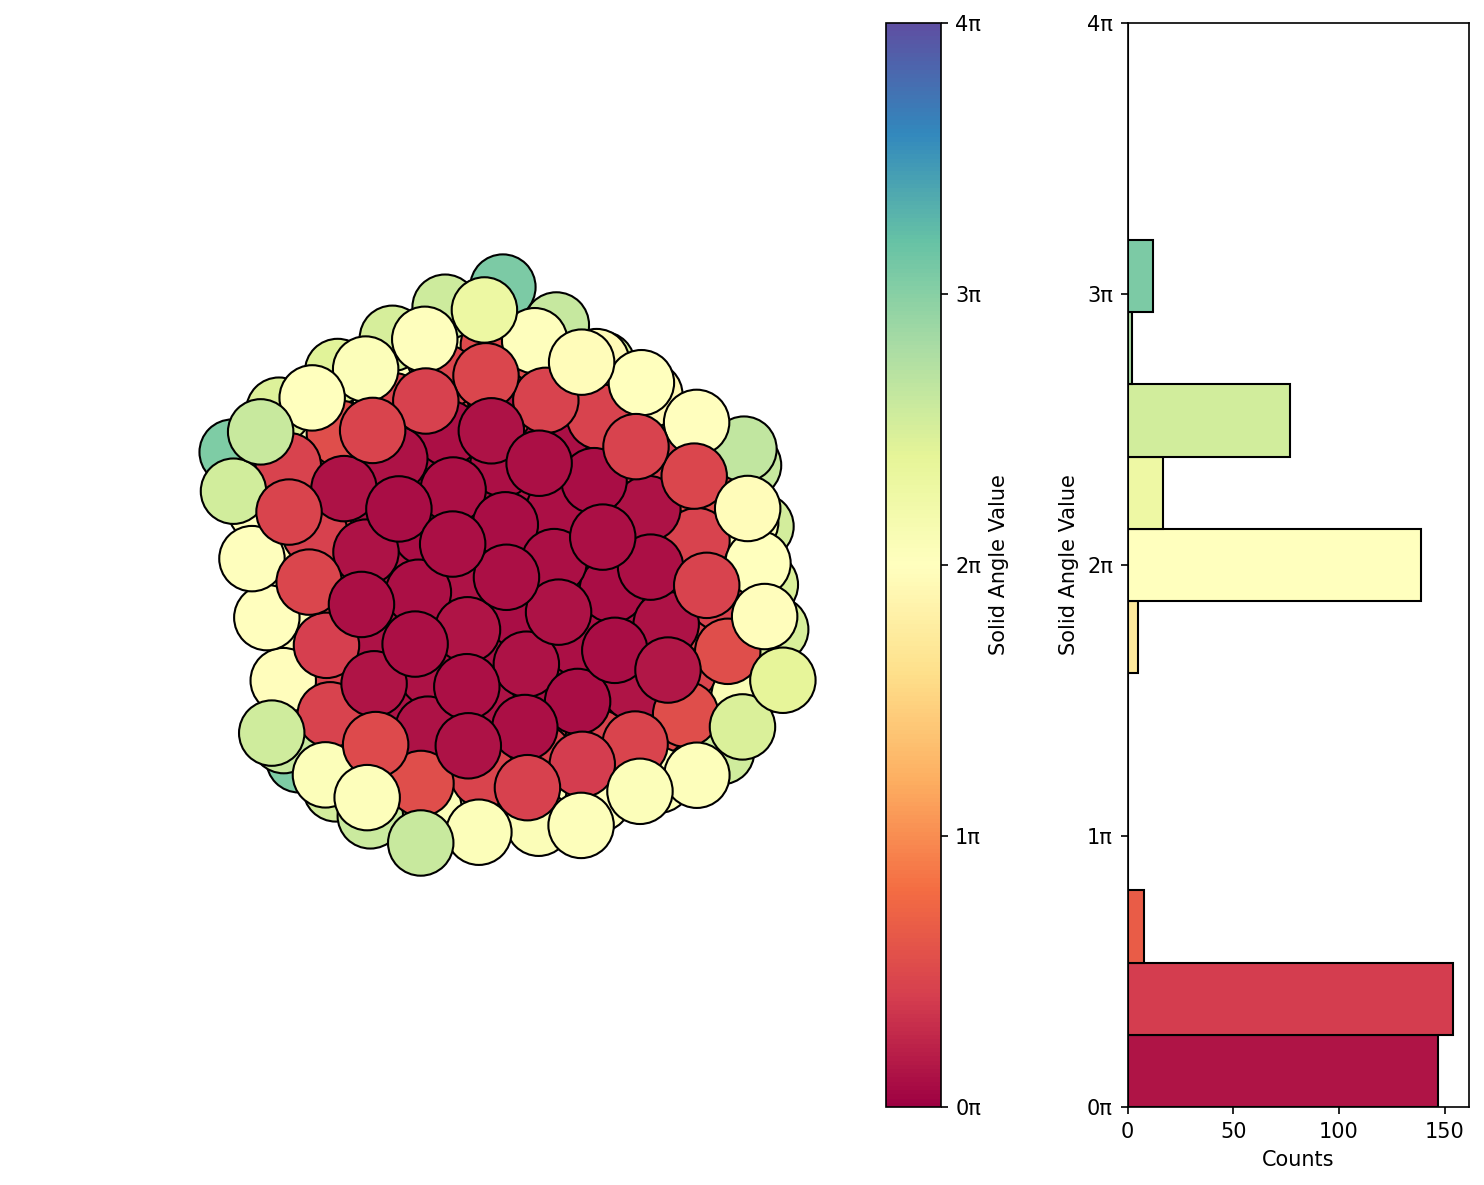

In [14]:
# Dictionary to store the average solid angle for each atom
average_solid_angles = {}

# Compute the average solid angle for each atom
for atom_id, solid_angles in all_solid_angles.items():
    average_solid_angles[atom_id] = np.average(solid_angles)

# Visualize the average solid angles
experiment.view.matplotlib_hinuma(experiment, solid_angles=average_solid_angles, cut=True, 
                                  rotation='90x, 0y, 0z', plot_histogram=True)

# Step 4: In-depth Analysis

In our continued exploration of the dataset, it's beneficial to compare the results under different configurations. By doing so, we can gain insights into the performance and adaptability of the Hinuma Algorithm.

## 4.1 Analyzing and Comparing Multiple Structures
To achieve this, we will introduce a different example and scrutinize the effects of tweaking certain parameters. Specifically, in this section, we will enable the Minimum Image Convention (MIC).

### Setting Up the Experiment

Let's start by defining the path to our example dataset and configuring the settings for our analysis:

*Note*: This can take a few minutes to compute.

In [15]:
path_xyz = 'examples/CuH2_example.xyz'

settings_dict = {
    'hinuma_cutoff': 5.0,  # Cutoff for the Hinuma algorithm
    'mic': True,  # Enable the minimum image convention
    'zero_vec_tolerance': 0.0000001,  # Tolerance level for zero vectors
    'init_frame_number': 5,  # Frame chosen for initial setup
    'solid_angle_limit': round(2 * 3.14 * 0.7, 3),  # Threshold solid angle to determine surface atoms
    
    'base_type_algorithm': 'chemical_elements',
    'chemical_elements': 'H C O',  # Target chemical elements for the analysis
}

# Initialize the experiment with the defined settings
experiment = data.import_experiment_from_file(path_xyz, settings_dict,
                                       import_positions=True)

# Compute the surfaces based on the experiment settings
surfaces = experiment.set_new_surfaces()

### Visualizing the Results

With our experiment set up, we can visualize the results to understand the spatial arrangement and properties of the atoms:

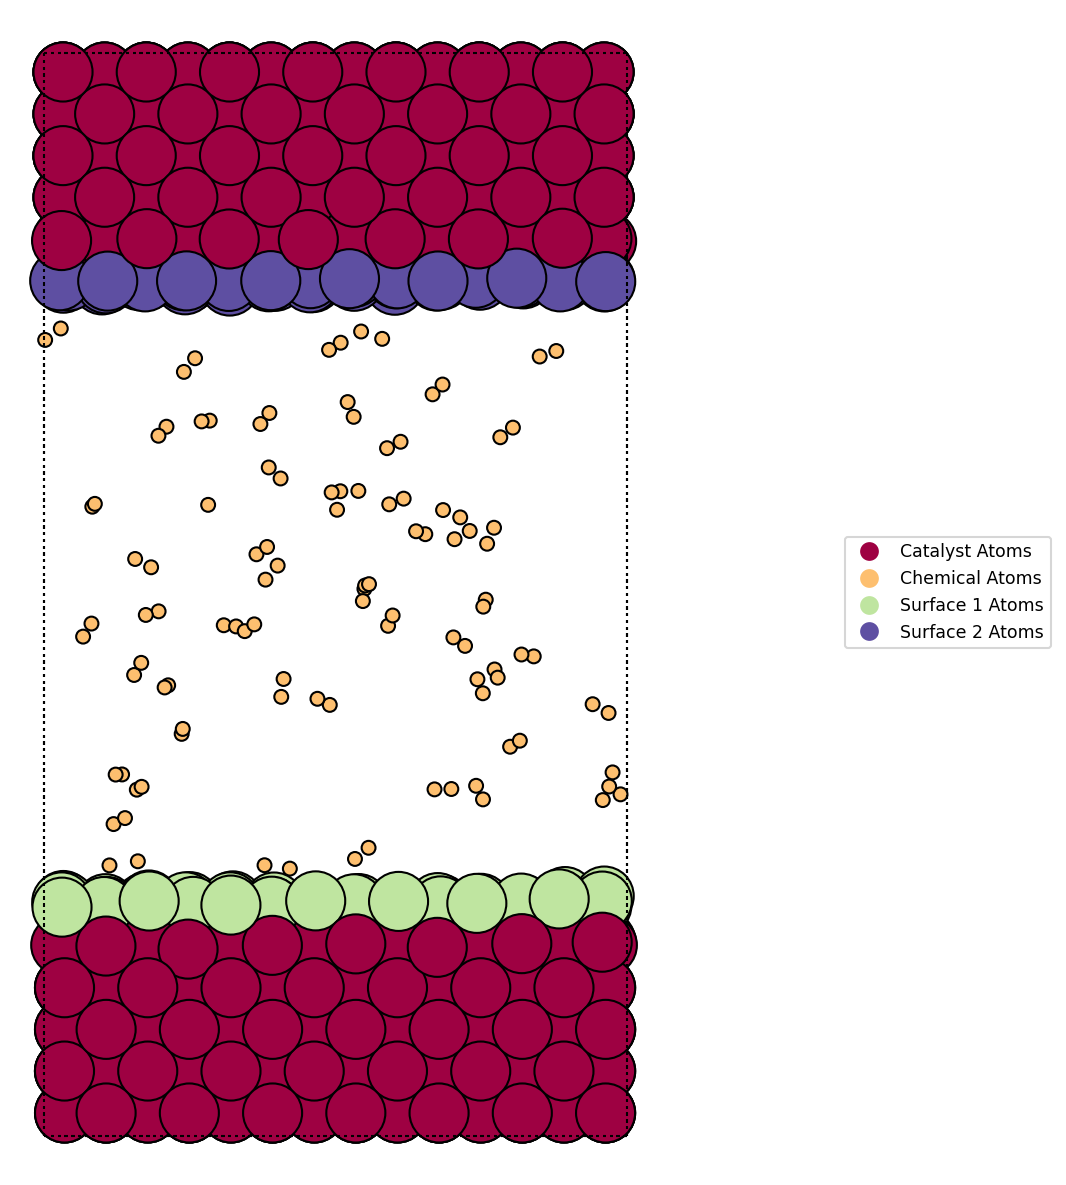

In [16]:
# Visualize the overall structure of the atoms
experiment.view.matplot(cut=True, rotation='90x, 0y, 0z')

Additionally, we can delve deeper into the Hinuma results, showcasing the computed solid angles and their distribution:

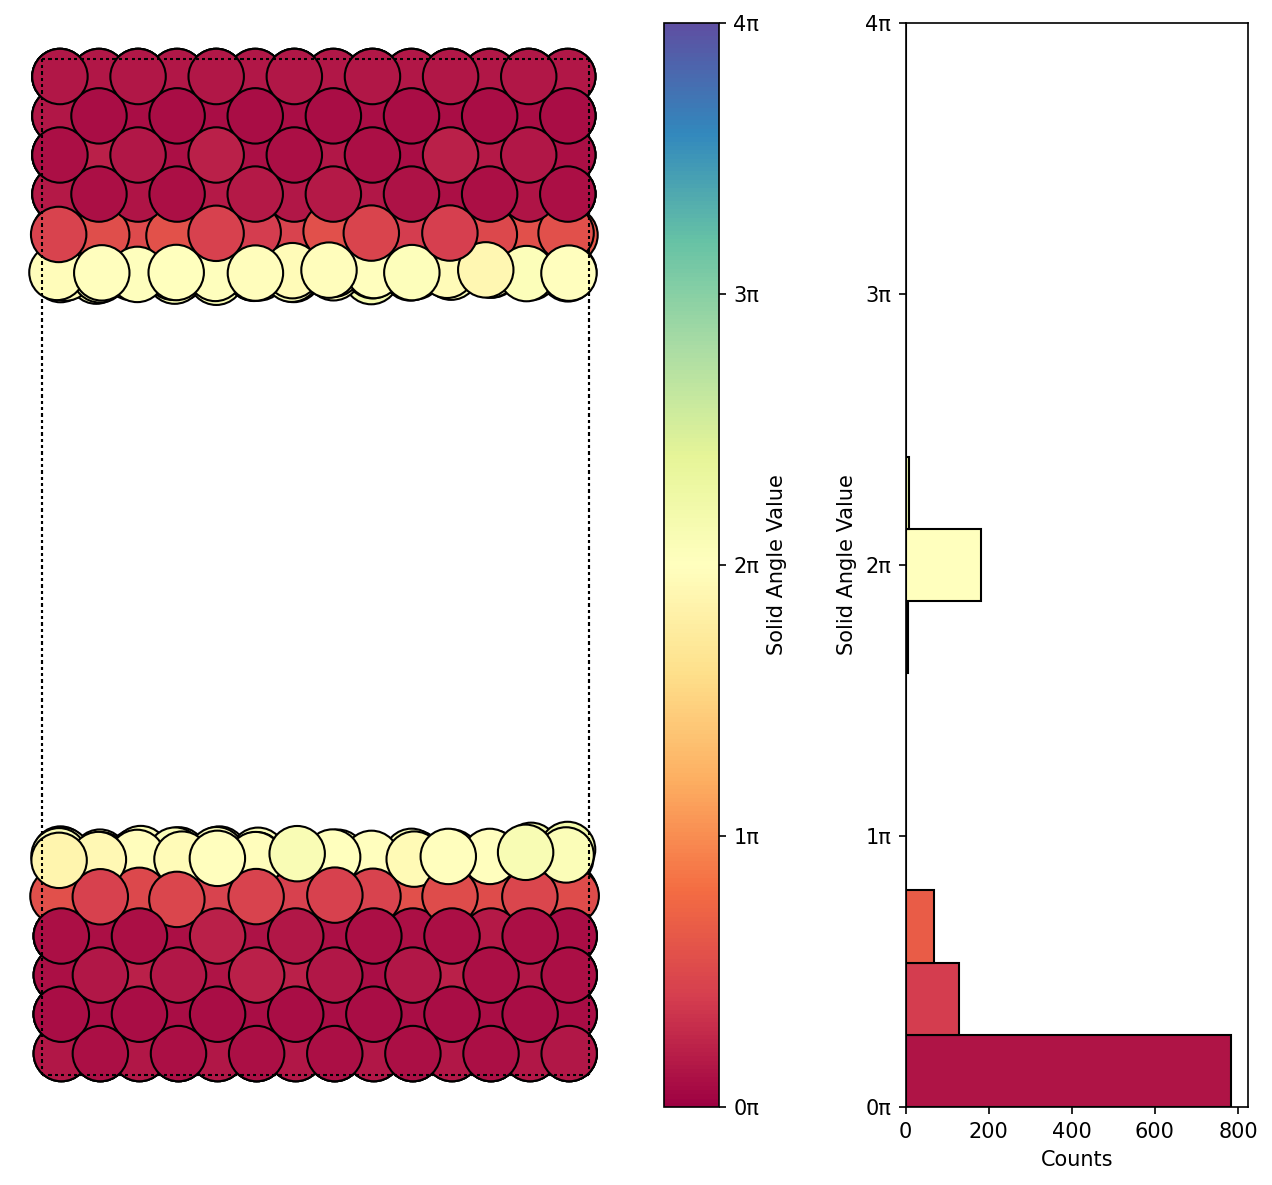

In [17]:
# Display the Hinuma results with a histogram representation
experiment.view.matplotlib_hinuma(experiment, hinuma_id=experiment.hinumas.latest_id(), 
                                  cut=True, rotation='90x, 0y, 0z', plot_histogram=True)


## 4.2 Constructing a Second Experiment for Comparison

To dive deeper into our analysis, we'll replicate the experiment for the same system but with a slight modification in the settings. Initially, we'll extract the system's ID from our previous experiment.

In [18]:
system_id = experiment.system_id

Now, let's define the new settings for our experiment. Notably, the Hinuma cutoff is adjusted from 5.0 Angstroms to 4.0 Angstroms, which can influence the calculation results.

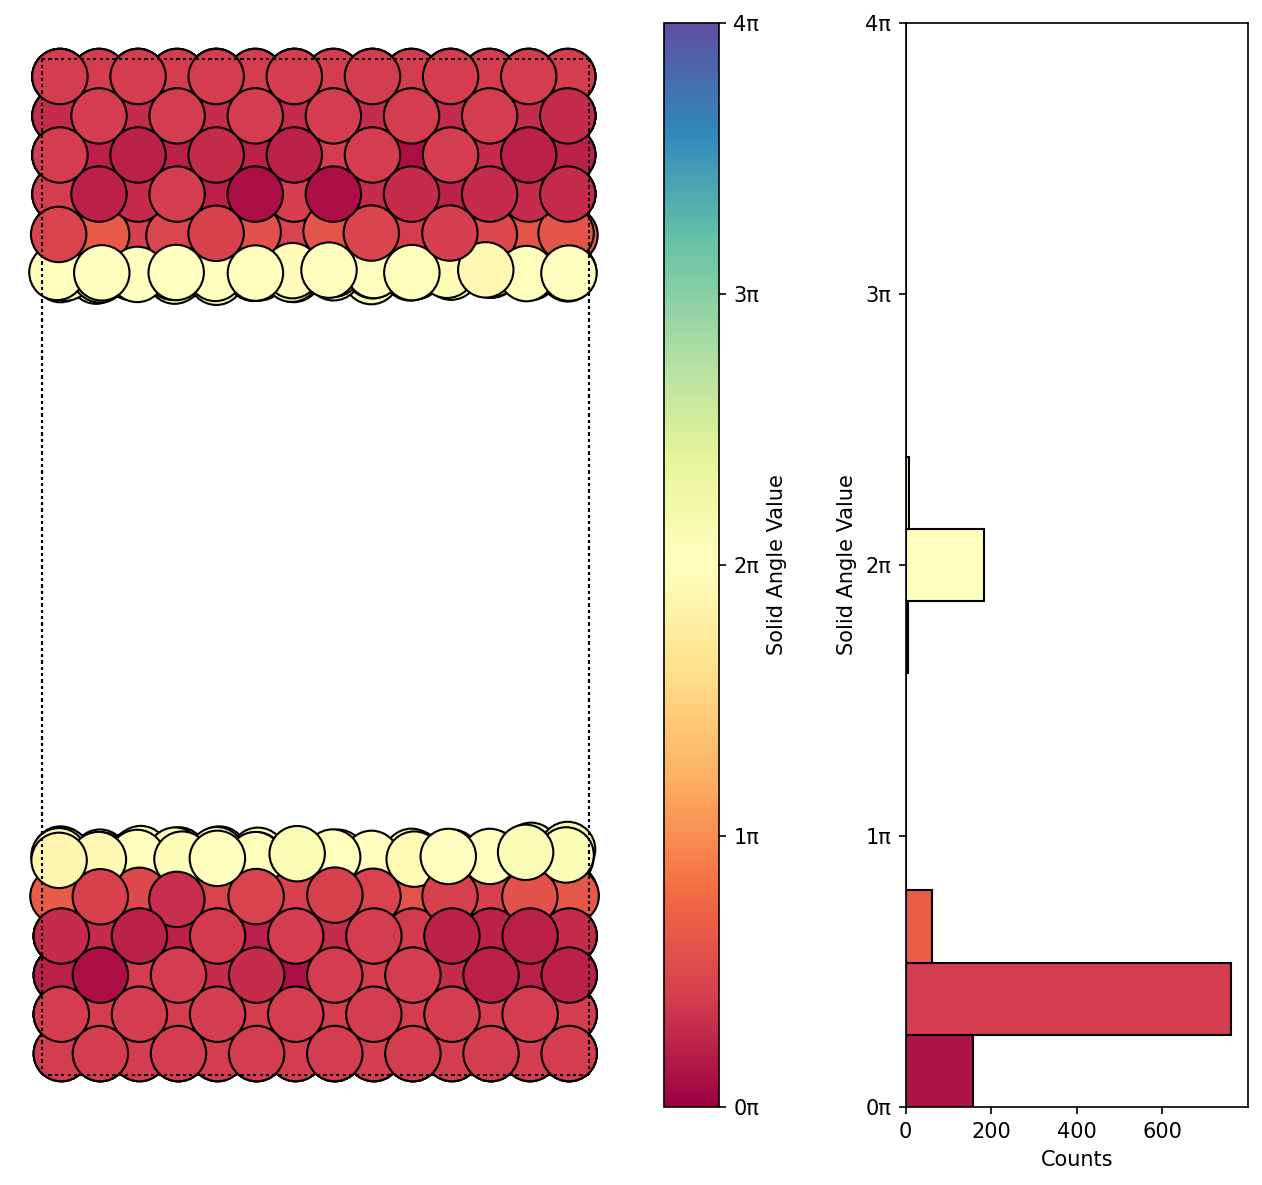

In [19]:
settings_dict = {
    'hinuma_cutoff': 4.0,  # Adjusted cutoff for Hinuma algorithm
    'mic': True,  # Employing the minimum image convention
    'zero_vec_tolerance': 0.0000001,  # Precision level for zero vectors
    'init_frame_number': 5,  # Selected frame for initialization
    'solid_angle_limit': round(2 * 3.14 * 0.7, 3),  # Threshold solid angle for identifying surface atoms
    
    'base_type_algorithm': 'chemical_elements',
    'chemical_elements': 'H C O',  # Target chemical elements for the study
}

# Applying the new settings
settings = data.settings.new_settings(settings_dict)

# Initializing the new experiment with adjusted settings
experiment = data.experiments.new(settings.setting_id, system_id=system_id)

# Calculating the surfaces based on the adjusted parameters
surfaces = experiment.set_new_surfaces()

# Visualizing the results with the modified settings
experiment.view.matplotlib_hinuma(experiment, hinuma_id=experiment.hinumas.latest_id(), 
                                  cut=True, rotation='90x, 0y, 0z', plot_histogram=True)

Despite the only notable change being the Hinuma cutoff adjustment, it's evident that reducing the cutoff can enhance computational efficiency. However, a side effect is that subsurface atoms may exhibit less distinct solid angle values.

## 4.3 Evaluating Connectivity for Hinuma Algorithm
For a comprehensive understanding, let's examine the connectivity utilized by the Hinuma algorithm. We'll start by listing all systems used in our analysis:

In [20]:
data.systems

{1: system_id=1, file_id=1, filename=FeCO_example.xyz,
 2: system_id=2, file_id=2, filename=CuH2_example.xyz}

Given our interest in the second system (`system_id=2`), we can fetch all its associated experiments:

In [21]:
data.systems[2].experiments

{2: experiment_id=2, system_id =2, setting_id=2,
 3: experiment_id=3, system_id =2, setting_id=3}

By iterating over these experiments, we can extract the latest Hinuma calculations:

In [22]:
hinumas = [data.experiments[experiment_id].hinumas.latest() for experiment_id in data.systems[2].experiments]

To discern the impact of our settings on connectivity, we'll extract the lengths of connection lists (which influence the Hinuma solid angles):

In [23]:
connections_len = defaultdict(dict)
for hinuma in hinumas:
    experiment = hinuma.experiment
    for atom_id, connections in hinuma.connections.items():
        connections_len[experiment.atoms.id_to_number[atom_id]][hinuma.id] = len(connections)

For a more succinct comparison between the two experiments, let's distill our findings into a set of tuples, representing unique connection lengths:

In [24]:
all_lenghts = set()
for connection_lenghts in connections_len.values():
    all_lenghts.add(tuple(connection_lenghts.values()))
all_lenghts

{(25, 12),
 (25, 13),
 (26, 12),
 (26, 13),
 (27, 13),
 (37, 17),
 (42, 17),
 (42, 18),
 (43, 18)}

Conclusively, the shift in the cutoff from 5.0 to 4.0 Angstroms considerably reduces the number of atoms factored into the Hinuma solid angle computation—nearly by half. Nevertheless, for straightforward surfaces, this modified approach remains effective in identifying surface atoms.

## 4.4 Analyzing Solid Angles of Surface and Subsurface Atoms

One insightful metric to consider in our analysis is the solid angles of atoms. By comparing the solid angles of surface atoms to those of subsurface atoms, we can discern patterns and characteristics unique to each category.

### Fetching the Latest Surface Group
Firstly, we'll retrieve the latest group of surfaces from our experiment. It's important to note that while we refer to multiple surfaces as a "surface group," a single Hinuma calculation yields one such group.

In [25]:
surfaces = data.experiments[3].surface_groups.latest
surfaces

SurfaceGroup ID 3 - Surfaces: 2

Our analysis correctly identified two surfaces in our structure. With this information in hand, we can now extract the hinuma_id associated with this surface group. We will then segregate the atom IDs into two categories: surface atoms and subsurface atoms.

In [26]:
hinuma_id = surfaces.hinuma_id
surface_atoms = list(surfaces.surface_atom_ids)
catalyst_atoms = surfaces.experiment.catalyst_ids

# Identifying subsurface atoms by excluding surface atoms from the total catalyst atoms
subsurface_atom_ids = set(catalyst_atoms).difference(surface_atoms)
print(f'Surface Atoms: {len(surface_atoms)}, Subsurface Atoms: {len(subsurface_atom_ids)}, Catalyst Atoms: {len(catalyst_atoms)}')


Surface Atoms: 196, Subsurface Atoms: 980, Catalyst Atoms: 1176


### Comparing Solid Angles
With our atom IDs categorized, we can now extract and compare the solid angles for both surface and subsurface atoms. This will provide insights into the spatial orientation and arrangement of these atoms.

Surface Atoms:

In [27]:
print('Solid Angle Limits for Surface Atoms')
surface_atoms_solid_angles = [experiment.hinumas[hinuma_id].solid_angles[atom_id] for atom_id in surface_atoms]
print(f'Minimum: {min(surface_atoms_solid_angles)}, Maximum: {max(surface_atoms_solid_angles)}')
print(f'Minimum: {round(min(surface_atoms_solid_angles)/np.pi, 3)} π, Maximum: {round(max(surface_atoms_solid_angles)/np.pi, 3)} π')

Solid Angle Limits for Surface Atoms
Minimum: 5.62760136268404, Maximum: 6.890733422501503
Minimum: 1.791 π, Maximum: 2.193 π


Subsurface Atoms:

In [28]:
print('Solid Angle Limits for Subsurface Atoms')
subsurface_atoms_solid_angles = [experiment.hinumas[hinuma_id].solid_angles[atom_id] for atom_id in subsurface_atom_ids]
print(f'Minimum: {min(subsurface_atoms_solid_angles)}, Maximum: {max(subsurface_atoms_solid_angles)}')
print(f'Minimum: {round(min(subsurface_atoms_solid_angles)/np.pi, 3)} π, Maximum: {round(max(subsurface_atoms_solid_angles)/np.pi, 3)} π')

Solid Angle Limits for Subsurface Atoms
Minimum: 0.3266516310310046, Maximum: 2.327657447698293
Minimum: 0.104 π, Maximum: 0.741 π


# Step 5: Investigating Surface Detection in OCP Trajectory

In this step, we shift our attention to another illustrative example, leveraging a trajectory from the Open Catalyst Project (OCP). The OCP trajectory uniquely tags atoms, and in our case, atoms tagged with '2' are recognized as chemical atoms. Furthermore, our goal is to focus solely on the upper surface layer. To achieve this, we'll employ a filter in our settings.

### Setting Up the OCP Experiment

In [29]:
path_xyz = 'examples/random207.extxyz'

# Configuration for the OCP experiment
settings_dict = {
    'hinuma_cutoff': 5.0,  # Cutoff for the Hinuma algorithm
    'mic': True,  # Using the minimum image convention
    'zero_vec_tolerance': 0.0000001,  # Tolerance for zero vectors
    'init_frame_number': 31,  # Frame for initialization
    'solid_angle_limit': round(2 * 3.14 * 0.7, 3),  # Solid angle threshold
    'xyz_filter': 'z_filter',  # Filter to focus on the upper surface layer
    'base_type_algorithm': 'chemical_tag',  # Base type algorithm selection
    'chemical_tag': 2,  # Tag for chemical atoms
}

# Initializing the experiment
experiment = data.import_experiment_from_file(path_xyz, settings_dict, import_positions=True)


To better understand our system's composition, let's discern the elements involved:

In [30]:
experiment.system.elements

['Hydrogen', 'Technetium', 'Aluminum']

### Surface Detection and Visualization
Now, we'll compute the surfaces and visualize the results to assess the efficacy of our detection:

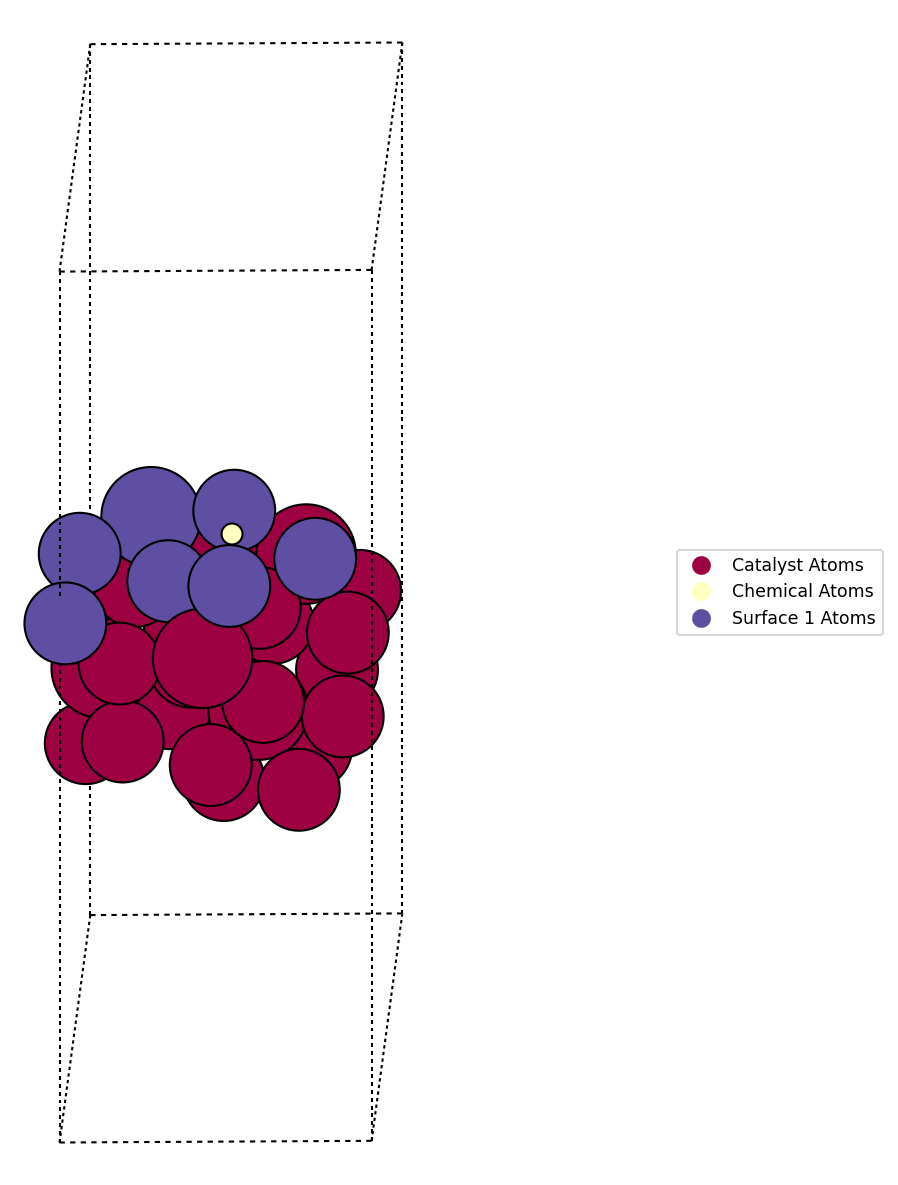

In [31]:
# Compute the surfaces with the defined settings
surfaces = experiment.set_new_surfaces()

# Visualize the atomic arrangement
experiment.view.matplot(cut=True, rotation='-50x, 0y, 0z')

For some datasets, a 2D representation might not sufficiently demarcate surface atoms from others. In such cases, a more interactive tool like the ASE GUI can aid in better understanding:

1. Execute the command below to initiate the ASE GUI.
2. Once in the GUI, select the atomic structure.
3. Use c on your keyboard to switch the coloring mode to 'By user defined tags'.

In [32]:
# Launch the ASE GUI for enhanced visualization
experiment.view.surfaces()

Lastly, let's examine the solid angle distribution of the catalyst atoms:

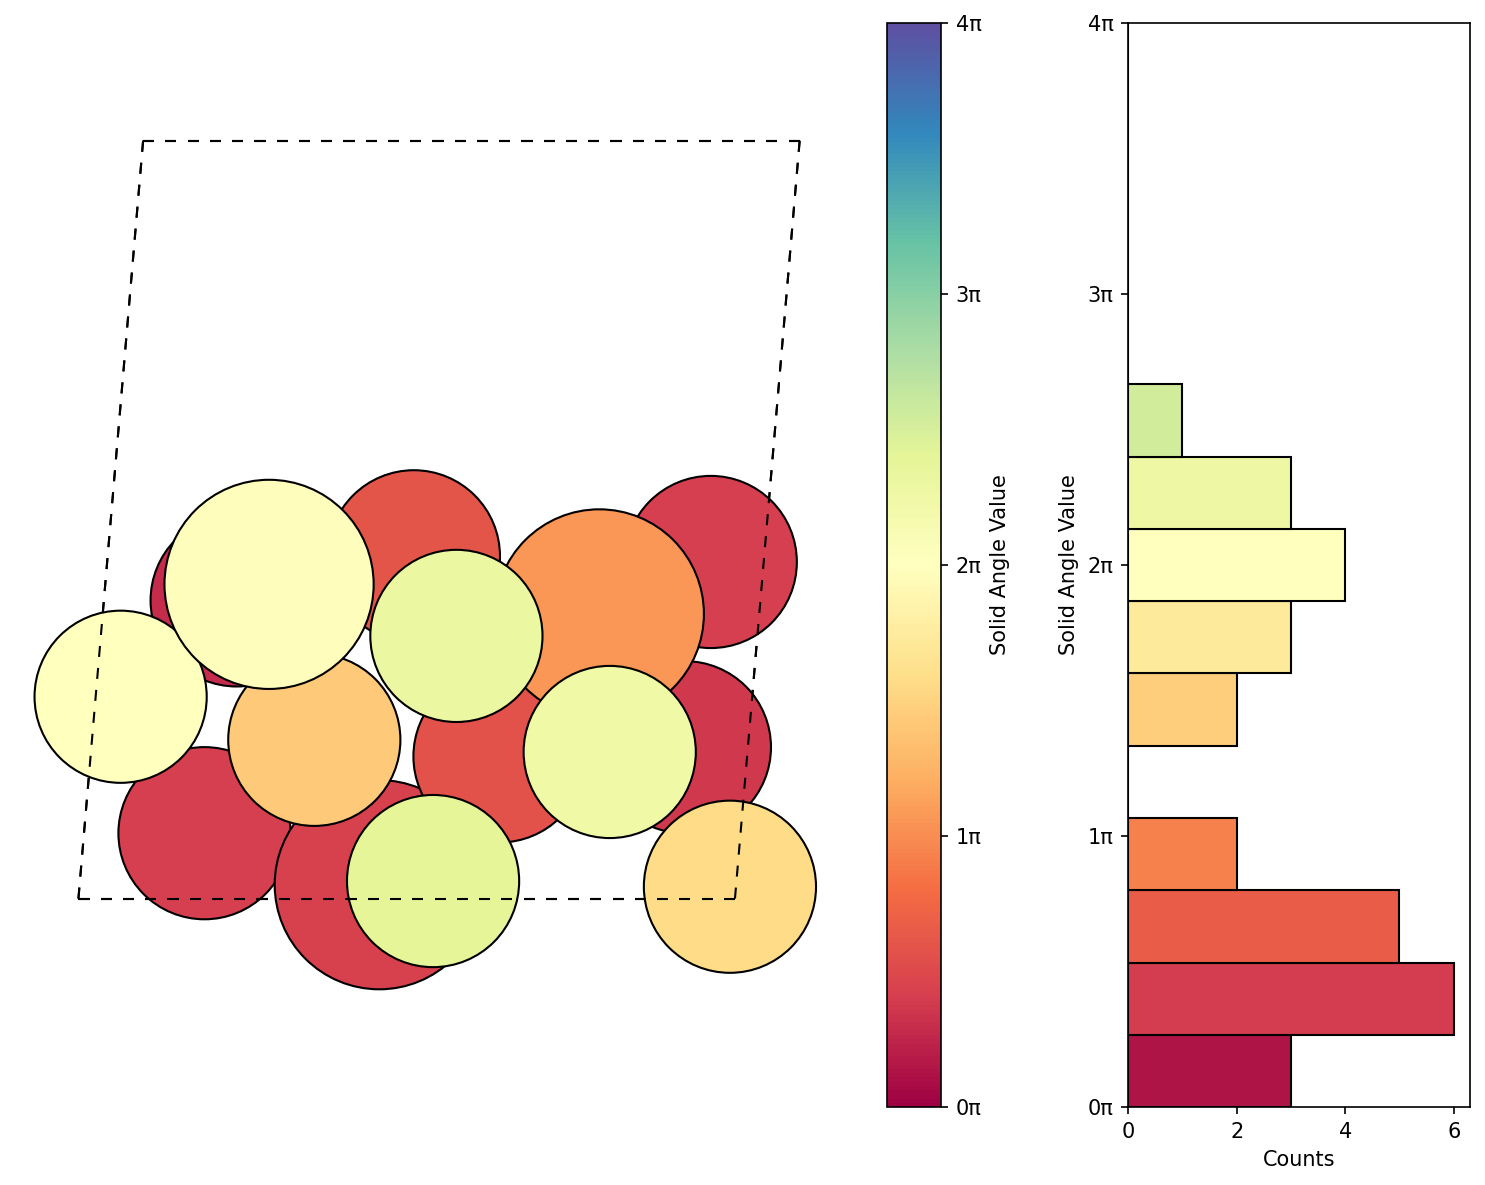

In [33]:
# Display the distribution of solid angles
experiment.view.matplotlib_hinuma(experiment, hinuma_id=experiment.hinumas.latest_id(), 
                                  cut=True, rotation='0x, 0y, 0z', plot_histogram=True)

From our observations, discerning surface atoms from others is more challenging in this example. Moreover, the solid angle distribution is notably broader than what we've seen in previous instances, highlighting the complexity of this system.

# Event Detection

In [34]:
system = data.systems[1]

In [35]:
# Settings dictionary for the tofhed package operations
settings_dict = {
    'hinuma_cutoff': 6.0,  # Cutoff radius (in Angstroms) for the Hinuma Algorithm
    'approach_cutoff': 4.0,
    'mic': False,  # Indicates if the calculation should apply the minimum image convention    'fudge_factor': 1.8,  # Fudge factor for bond/connection detection
    'fudge_factor': 1.7,  # Fudge factor for bond/connection detection

    'zero_vec_tolerance': 0.0000001,  # Threshold for the zero vector
    'init_frame_number': 5,  # Frame number for initialization
    'solid_angle_limit': round(2 * 3.14 * 0.7, 3),  # Solid angle threshold for surface atoms
    'duration_cutoff': 3, # Cutoff for duration of events

    'base_type_algorithm': 'chemical_elements',  # Algorithm for distinguishing catalyst from chemical atoms
    'chemical_elements': 'H C O',  # List of chemical elements for chemical atoms
}

In [36]:
settings = data.settings.new_settings(settings_dict)

In [37]:
experiment = data.experiments.new_experiment(settings.setting_id, 
                                             system_id=system.system_id,
                                             note='Event Detection')

In [38]:
# Detecting surfaces of the system
surfaces = experiment.set_new_surfaces()
print(surfaces)

SurfaceGroup ID 5 - Surfaces: 1


In [39]:
surfaces.id

5

In [40]:
events = experiment.events.pyykko_event_detection(surface_group_id=surfaces.id, write_to_db=True)

1697102791.2845905 get capped distances start
0.0695805549621582 made pairs
0.7974603176116943 got from memory
5.743305683135986 read from db


7.292691230773926 calculated distances
10.088351011276245 wrote to db
10.100926876068115 updated to memory


In [41]:
import tofhed

event_analysis = tofhed.analysis.EventAnalysis(experiment)
df = event_analysis.extended_analysis(duration_cutoff=3)
df

frame_number  chem_number  catalyst_number  duration  distance  hopping  \
83               0          569              431         1  1.410145    False   
68               0          570              407         1  1.619102    False   
8                0          577              398         1  2.298091    False   
49               0          578              398         1  2.085998    False   
98               0          630              461         1  2.131869    False   
...            ...          ...              ...       ...       ...      ...   
4895            48         1153              537        49  2.120749    False   
4922            48         1155              471         9  2.465724    False   
4887            48         1157              523        49  1.999940    False   
4907            48         1159              321        49  1.724965     True   
4841            48         1160              386        49  2.831369     True   

      adsorbed  solid_angle  
83        True     8.267245  
68        True     6.137954  
8         True     7.688967  
49       False     7.688967  
98       False     7.091343  
...        ...          ...  
4895      True     8.224449  
4922      True     6.263625  
4887      True     6.984863  
4907      True     6.875967  
4841      True     7.467563  

[4927 rows x 8 columns]